In [1]:
#Import the modules required for the subsequent calculations.
import numpy 
from matplotlib import pyplot
%matplotlib inline

from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()

#Numerical Hydrodynamics Assignment
##Introduction
This report will investigate the hydrodynamic characteristics of several different geometries. This will be done using numerical and analytical methods to predict pressure and force characteristics about the following geometeries:

1. A circular cyclinder;
1. A joukowski foil;
1. A cambered joukowski foil.

The analysis performed on each geometry will be described in more detail in the respective sections.

##A Circular Cylinder
A circular cylinder is one of the simpler 2D geometries for which numerical and analytical analysis may be performed. As a result it allows numerical results to be easily compared with experimental values to enable validation of methods.

The analysis required for this geometry is as follows:
1. To compute the pressure coefficient $c_p$ on the surface for three resolutions $N=32,64,128$, and compare the results to the exact potential flow solution.
1. To compute the friction drag coefficient $C_F$, and an estimate for the pressure drag coefficient $C_D$ for the same three resolutions at $Re_D=10^5$. 

###Method
#### Computing the Pressure Coefficient 

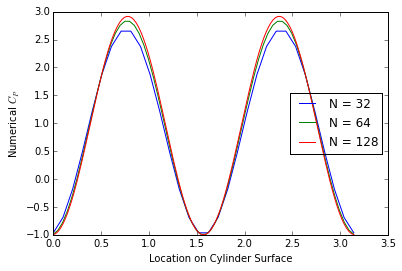

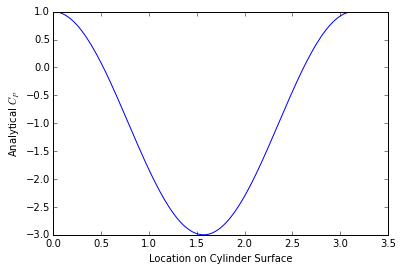

In [11]:
#Import the required functions from VortexPanel.py and BoundaryLayer.py
from VortexPanel import Panel, solve_gamma, plot_flow, make_circle

#Create function to calculate the pressure coefficient
def cp(gamma): return gamma**2-1

def calc_Cp(u_e, U_inf=1):
    #Find analytical result for Cp.
    Cp = []
    Cp = [(1-((i**2)/(U_inf**2))) for i in u_e]
    return Cp

N = [32, 64, 128] #Create list of resolutions

for n in N:
    s = numpy.linspace(0, numpy.pi, n) #Points about the circumference of the circle
    circle = make_circle(n) #Create geometry
    solve_gamma(circle)
    c_p = numpy.zeros(n)
    for i,p_i in enumerate(circle): c_p[i] = cp(p_i.gamma)
    pyplot.plot(s, c_p, label = "N = %.f" % n)
    pyplot.legend(loc='best')
    pyplot.xlabel('Location on Cylinder Surface')
    pyplot.ylabel('Numerical $C_P$')

s = numpy.array(numpy.linspace(0, numpy.pi, N[2]))
u_e = 2.*numpy.sin(s)
pyplot.figure()
pyplot.plot(s, calc_Cp(u_e))
pyplot.xlabel('Location on Cylinder Surface')
pyplot.ylabel('Analytical $C_P$')


#### Computing the Friction Drag Coefficient

In [22]:
#Import and create some useful functions.
#These functions are fully explained in the comprehensive series of hydrodynamic ipython notebooks by Dr Wemouth, UoS.
from BoundaryLayer import heun, g_pohl, Pohlhausen, march

def pohlF(eta): return 2*eta-2*eta**3+eta**4
def pohlG(eta): return eta/6*(1-eta)**3
def disp_ratio(lam): return 3./10.-lam/120.
def mom_ratio(lam): return 37./315.-lam/945.-lam**2/9072.
def df_0(lam): return 2+lam/6.
def g_1(lam): return df_0(lam)-lam*(disp_ratio(lam)+2*mom_ratio(lam))

from scipy.optimize import bisect
lam0 = bisect(g_1,-12,12) 

#Useful information 
nu= 1e-5
N = 32
s = numpy.linspace(0, numpy.pi, N)
u_e = 2.*numpy.sin(s)
du_e = 2.*numpy.cos(s)
delta, lam, iSep = march(s, u_e, du_e, nu)

Flat Plate: 2.37e-03
Circle: 4.04e-03


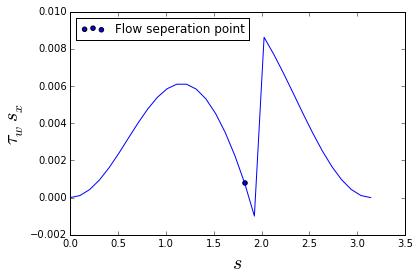

In [38]:
from numpy import trapz


def T_w(N,nu):
    s = numpy.linspace(0,numpy.pi,N)  
    u_e= 2.*numpy.sin(s)
    rho=1
    du_e=2.*numpy.cos(s)
    delta,lam,iSep = march(s,u_e,du_e,nu) 
    Re_d = delta*u_e/nu
    half_cf=[]
    for i in range(N):
        if Re_d[i]==0:
            half_cf.append(0.0)
        else:
            half_cf.append(df_0(lam[i])/Re_d[i])
            
    return half_cf*rho*(u_e**2)

s_x=numpy.sin(s)
nu=1e-5

def F_F(lam,nu,delta,u_e,s_x): 
#     s_x=numpy.sin(s)
      T_w2=T_w(N,nu)
      return (trapz(T_w2[0:iSep+1]*s_x[0:iSep+1],s[0:iSep+1]))


def C_F(N,nu,rho=1,S=1,U_inf=1):
    return(2*F_F(N,nu))/(rho*U_inf*S)


C_F_flat= 1.33*numpy.sqrt(nu/s[-1])
print('Flat Plate: '+'%.2e' %C_F_flat)

C_F_circle= 2*F_F(lam,nu,delta,u_e,s_x)/s[-1]

print('Circle: '+'%.2e' %C_F_circle)

tau = T_w(N,nu)

pyplot.plot(s,tau*s_x)
pyplot.scatter(s[iSep], tau[iSep]*s_x[iSep], label='Flow separation point')
pyplot.xlabel('$s$',size=20)
pyplot.ylabel(r'$\tau_w s_x$', size=20)
pyplot.gca().set_xlim([0, 3.5])
pyplot.gca().set_ylim([-0.002, 0.01])
pyplot.legend(loc='best')
pyplot.show()

####Computing the Friction Drag Coefficient

5.90192968099


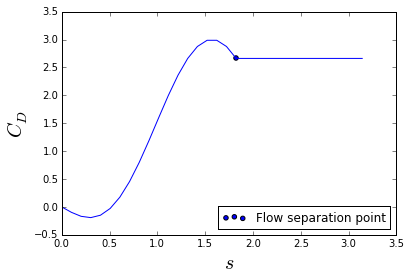

In [37]:
def solve_C_d(u_e,iSep,s):
    Sy = [-1*numpy.sin(i) for i in s]
    k=0
    C_p = calc_Cp(u_e)
    for j in range(0,len(C_p)):
        if j >iSep:
                C_p[j] = C_p[iSep]
        else:
                C_p[j]=C_p[j]*Sy[j]
    pyplot.plot(s,C_p)
    pyplot.xlabel('$s$',size=20)
    pyplot.ylabel(r'$C_D$', size=20)
    pyplot.gca().set_xlim([0, 3.5])
    pyplot.gca().set_ylim([-0.5, 3.5]) 
    pyplot.scatter(s[iSep], C_p[iSep], label='Flow separation point')
    pyplot.legend(loc='lower right')
    
    return numpy.trapz(C_p,s)

nu = 1e-5
N=32
s=numpy.linspace(0,numpy.pi,N)
u_e= 2.*numpy.sin(s)
du_e = 2.*numpy.cos(s)
delta,lam,iSep= march(s,u_e,du_e,nu)

print (solve_C_d(u_e,iSep,s))

###Analysis

##Joukowski Foil
The geometry for the joukowski foil is easily generated using the ''Joukowski Transform" which takes a circle in the xy plane and transforms it to the $\zeta$ plane. The equation is given as follows.

$$ \zeta = z + \frac 1z$$

A function for this geometry has already been programmed and will be imported into this notebook.

The analysis required for this foil is detailed as follows:
- To compute the lift coefficient $C_L$ as a function of the angle of attack $\alpha\le 10^o$ for three resolutions $N=32,64,128$, and and to compare the results to the exact potential flow solution.
- To compute the separation point location on either side of the foil for the same angle of attack range for $N=128$.

###Method

####Calculating the Lift Coefficient

In [25]:
from VortexPanel import make_jukowski, solve_gamma_kutta

#Analytical solution for this jukowski geometry
def jukowski_CL(alpha,t_c=0.15+0.019): return 2.*numpy.pi*(1+4/3/numpy.sqrt(3)*t_c)*numpy.sin(alpha)

alpha = numpy.linspace(0, 10./180*numpy.pi, 11) #Compute range of angles, this is done for every integer. It is possible for a greater level of detail through increasing the third variable in the function.
N = [32, 64, 128] #List of panel numbers or resolutions.

analytic = jukowski_CL(alpha) 

degrees = numpy.linspace(0, 10, 11) #For the graph axis

def lift(panels):
    #A function to calculate the lift generated from a group of panels.
    c = panels[0].x[0]-panels[len(panels)/2].x[0]      
    return -4./c*numpy.sum([p.gamma*p.S for p in panels])

Now to create a function to calculate the lift coefficent from a joukowski foil given an angle of attack, $\alpha$, and number of panels, N.

In [26]:
def calc_CL(alpha, N):
    foil = make_jukowski(N)
    solve_gamma_kutta(foil, alpha)
    return lift(foil)

C_L = [] #Create empty list. This is a lazy method, a computationally faster method would be to use arrays. However this is quick to program.
for i in N:
    empty = []
    for j in alpha:
        empty.append(calc_CL(j, i))
    C_L.append(empty)

These results are understood best graphically.

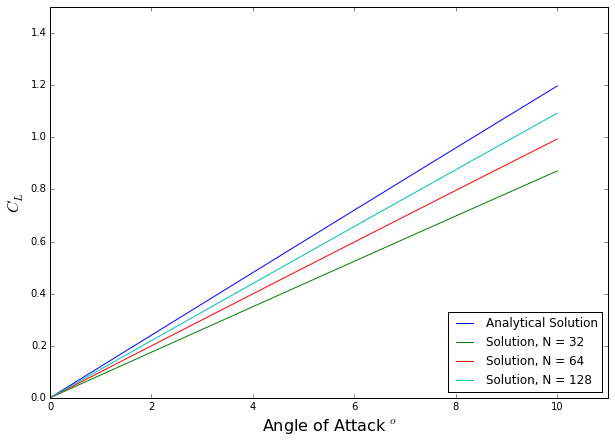

In [27]:
pyplot.figure(figsize=(10,7))
pyplot.plot(degrees, analytic, label=r'Analytical Solution' )
pyplot.plot(degrees, C_L[0], label=r'Solution, N = 32')
pyplot.plot(degrees, C_L[1], label=r'Solution, N = 64')
pyplot.plot(degrees, C_L[2], label=r'Solution, N = 128')
pyplot.legend(loc='lower right')
pyplot.xlabel(r'Angle of Attack $^o$', fontsize=16)
pyplot.ylabel(r'$C_L$', fontsize=16)
axes = pyplot.gca()
axes.set_xlim([0,11])
axes.set_ylim([0,1.5])
pyplot.show()

#### Calculating the Flow Separation Points

In [28]:
from BoundaryLayer import Pohlhausen, march 

def solve_plot_boundary_layers_1(panels,alpha=0,nu=1e-5):
    #Function from boundarylayer module, with the plot lines commented out.
    from VortexPanel import plot_flow
    from matplotlib import pyplot
    
    # Set up and solve the top boundary layer
    top_panels = [p for p in panels if p.gamma<=0]      # negative gamma on the top
    top = Pohlhausen(top_panels,nu)
    top.march()
    
    # Set up and solve the bottom boundary layer
    bottom_panels = [p for p in panels if p.gamma>=0]     # positive gamma on the bottom
    bottom_panels = bottom_panels[::-1]                 # reverse array so 0 is stagnation
    bottom = Pohlhausen(bottom_panels,nu)
    bottom.march()
    
    # plot flow with stagnation points
    #plot_flow(panels,alpha)
    #pyplot.scatter(top.xSep, top.ySep, s=100, c='r')
    #pyplot.scatter(bottom.xSep, bottom.ySep, s=100, c='g')
    
    return top,bottom

def predict_jukowski_separation(t_c,alpha=0,N=128):
    #Function from separation prediction and altered to return a value.
    # set dx to gets the correct t/c
    foil = make_jukowski(N,dx=t_c-0.019) #t_c-0.019 is the shift from t/c to dx

    # find and print t/c
    x0 = foil[N/2].xc
    c = foil[0].xc-x0
    t = 2.*numpy.max([p.yc for p in foil])
    #print "t/c = "+"%.3f"%(t/c)

    # solve potential flow and boundary layer evolution
    solve_gamma_kutta(foil,alpha)
    top,bottom = solve_plot_boundary_layers_1(foil,alpha)

    #Return point of seperation
    return (top.x_sep-x0)/c, (bottom.x_sep-x0)/c

In [29]:
sep_point = [] #Create empty list as it's easy.
for a in alpha:
    sep_point.append(predict_jukowski_separation(0.15, a))
sep_point = numpy.array(sep_point) # Turn sep_point from list into an array

Now to plot the graph of these results.

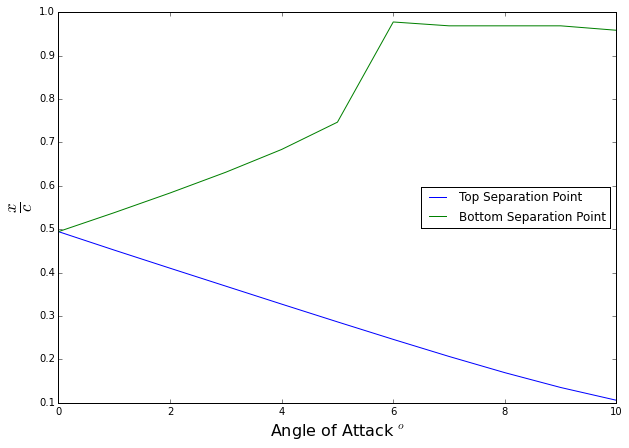

In [30]:
pyplot.figure(figsize=(10,7))
pyplot.ylabel(r'$\frac{x}{c}$', fontsize=24)
pyplot.xlabel(r'Angle of Attack $^o$', fontsize=16)
pyplot.plot(degrees, sep_point[:,0], label=r'Top Separation Point')
pyplot.plot(degrees, sep_point[:,1], label=r'Bottom Separation Point')
pyplot.legend(loc='right')
pyplot.show()

###Analysis

##Cambered Joukowski Foil
The geometry is the 15% Jukowski foil with camber, quantified by the height of the mean line at $x=0$, ie  $\bar y = \frac 12 (y[N/4]+y[3N/4])$.

The the lift force coefficient $C_L$ and boundary layer separation point locations for $\bar y/c = 0.02,0.04,0.08$ at $\alpha=0$ using $N=128$ panels are required, then a comparision to the symetric foil solution needs to be completed.

###Method
####Generating the Foil Geometry
Altering the dy input to the make_jukowski function alters the camber of the foil, however it is unknown what the exact linear relationship is. From the Joukowski transform equation in the first section of this report, the following equation is true.
$$ dy \propto \bar y $$
As a result this relationship must be investigated, it is likely that for a particular foil geometry there will be an empirical factor that works for that case in particular. First a function is required to give the distance $\bar y$ when given dy.

In [31]:
def camber(t_c, alpha, dy, N=128):
    #Function to find empirical relationship between dy and camber.
    dx=t_c-0.019
    foil = make_jukowski(N, dx, dy)
    #plot_flow(foil, alpha) #Can be commented in to inspect the shape of the foil
    a = int(N/4)
    b = int((3*N)/4)
    y_bar = 0.5*(foil[a].yc + foil[b].yc)
    return y_bar

trial_dy = numpy.linspace(0, -1, 30) #Range of experimental values for dy
y_bar = [] #Create empty list.
for i in trial_dy:
    y_bar.append(camber(0.15, 0, i, 128))

Create a function to give the:
1. Graphical relationship between dy and $\bar y$ to confirm its linearity.
1. Give the gradient of the relationship.


Multiply the dy value by -0.84675 to obtain the ybar/c value for the foil geometry chosen.


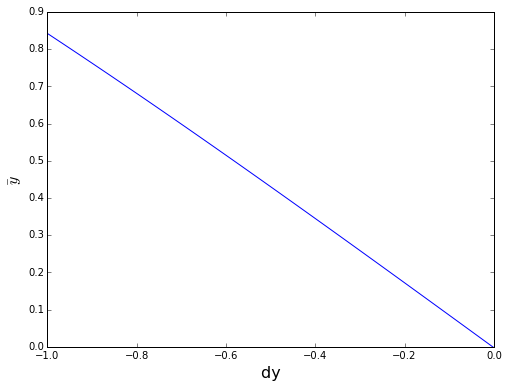

In [32]:
#Investigating the relationship between dy and y_bar
def camber_emp(trial_dy, y_bar):
    from sklearn.linear_model import LinearRegression 
    #This is a module developed for machine learning. It is useful for this sort of analysis.
    X = trial_dy[:, numpy.newaxis] 
    regr = LinearRegression() 
    regr.fit(X, y_bar)
    fig = pyplot.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)   
    pyplot.ylabel(r"$\bar y$ ",fontsize=16)
    pyplot.xlabel("dy ",fontsize=16)
    pyplot.plot(trial_dy, y_bar)
    pyplot.gca().set_xlim(left=-1)
    pyplot.gca().set_ylim(bottom=0) 
    print("Multiply the dy value by %.5f to obtain the ybar/c value for the foil geometry chosen." % regr.coef_)
    pyplot.show()
    return regr.coef_

coef = camber_emp(trial_dy, y_bar)

This is clearly a linear relationship so it is certainly appropriate to use this value generated. The following relationship between these factors can be derived.
$$\frac{\bar y/c}{-0.84675} = dy$$

####Computing the Lift Coefficent and Separation Points for Different Cambers
Take functions used earlier in this report and alter to account for camber.

In [33]:
def predict_jukowski_separation_camber(t_c, y_bar_c, alpha=0,N=128):
    #Function from separation prediction and altered to account for camber.
    # set dx to gets the correct t/c
    dx = t_c  -0.019
    dy = y_bar_c/(-0.84675)
    foil = make_jukowski(N, dx, dy) #t_c-0.019 is the shift from t/c to dx
    x0 = foil[N/2].xc
    c = foil[0].xc-x0
    t = 2.*numpy.max([p.yc for p in foil])

    # solve potential flow and boundary layer evolution
    solve_gamma_kutta(foil,alpha)
    top,bottom = solve_plot_boundary_layers_1(foil,alpha)

    #Return point of separation
    return (top.x_sep-x0)/c, (bottom.x_sep-x0)/c

def calc_CL_camb(alpha, N, t_c, y_bar_c):
    #Function from earlier in this report altered to account for camber.
    dx = t_c - 0.019
    dy = y_bar_c/(-0.84675)
    foil = make_jukowski(N, dx, dy)
    solve_gamma_kutta(foil, alpha)
    return lift(foil) 

fill_val = jukowski_CL(0) #The lift coefficient for the symmetric foil.
analytic = numpy.full_like(y_bar_c, fill_val) #Python will get sad unless it gets an array of analytical C_L to plot.
analytic

NameError: name 'y_bar_c' is not defined

Find the $C_L$ values and separation points for the various cambers.

In [ ]:
y_bar_c = [0.02, 0.04, 0.08] #List of cambers.
c_l = []
for i in y_bar_c:
    c_l.append(calc_CL_camb(0, 128, 0.15, i))
sep_points_camber = []
for i in y_bar_c:
    sep_points_camber.append(predict_jukowski_separation_camber(0.15, i, 0, 128))
sep_points_camber = numpy.array(sep_points_camber)

Now to visually inspect these results. 

In [ ]:


fig, ax1 = pyplot.subplots(figsize=(10,7))
ax2 = ax1.twinx()
ax1.set_ylabel(r'$C_L$', fontsize=16)
ax1.set_xlabel(r'$\frac{\bar{y}}{c}$', fontsize=28)
ax1.scatter(y_bar_c, c_l, label=r'Numerical $C_L$')
ax1.plot(y_bar_c, analytic, label=r'Symmetric Foil $C_L$', color='black')
ax2.scatter(y_bar_c, sep_points_camber[:,1], label=r'Bottom Separation Point',color='red')
ax2.scatter(y_bar_c, sep_points_camber[:,0], label=r'Top Separation Point',color='green')
ax2.set_ylabel(r'$\frac{x}{c}$', fontsize=28)
ax1.legend(loc='best')
ax2.legend(loc='right')

In [ ]:
#Plot the separation points.
pyplot.figure(figsize=(8, 8))
pyplot.scatter(y_bar_c, sep_points_camber[:,1], label=r'Bottom Separation Point',color='red')
pyplot.scatter(y_bar_c, sep_points_camber[:,0], label=r'Top Separation Point',color='green')
pyplot.ylabel(r'$\frac{x}{c}$', fontsize=28)
pyplot.xlabel(r'$\frac{\bar{y}}{c}$', fontsize=28)
pyplot.legend(loc='best')
pyplot.show()

#Plot the lift coefficents.
pyplot.figure(figsize=(8, 8))
pyplot.ylabel(r'$C_L$', fontsize=16)
pyplot.xlabel(r'$\frac{\bar{y}}{c}$', fontsize=28)
pyplot.scatter(y_bar_c, c_l, label=r'Numerical $C_L$')
pyplot.plot(y_bar_c, analytic, label=r'Symmetric Foil $C_L$', color='black')
pyplot.legend(loc='best')
pyplot.show()

####Analysis

##Conclusion